<a href="https://colab.research.google.com/github/ogatash-lab/ICICS2023EvalData/blob/main/CVSS_MLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import sklearn
print(sklearn.__version__)
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from numpy.lib.function_base import vectorize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.core.fromnumeric import size
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import tqdm
import time
import json
import re
import csv
import urllib.request
import shutil

1.2.2


In [ ]:
import time
# 結果保存用
df_result = pd.read_csv("https://raw.githubusercontent.com/mus-shd/CVSS-BERT/main/data/cve_2018-2020_y_test.csv", header=0)
df_result["CVE-ID"] = pd.read_csv("https://raw.githubusercontent.com/mus-shd/CVSS-BERT/main/data/cve_2018-2020_X_test.csv", header=0)["CVE_ID"]
df_comparison = pd.DataFrame()


# metrics = ['cvssV3_attackVector','cvssV3_attackComplexity','cvssV3_privilegesRequired','cvssV3_userInteraction',
#            'cvssV3_scope','cvssV3_confidentialityImpact','cvssV3_integrityImpact','cvssV3_availabilityImpact']
metrics = ['cvssV3_attackVector']


acu = []

for metric in metrics:
  # 提案手法のdata--------------------------------------------------------------
  # df = pd.read_csv("https://raw.githubusercontent.com/sho6210/SecDev2023/main/data/cve_2018-2020_complete_dataset.csv", header=0)
  # X = pd.DataFrame(df[['Description']])
  # y = pd.DataFrame(df[[metric]])
  # train_sentence, test_sentence, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)

  # 従来手法のdata-------------------------------------------------------------
  train_sentence = pd.read_csv("https://raw.githubusercontent.com/mus-shd/CVSS-BERT/main/data/cve_2018-2020_X_train.csv", header=0)
  test_sentence = pd.read_csv("https://raw.githubusercontent.com/mus-shd/CVSS-BERT/main/data/cve_2018-2020_X_test.csv", header=0)
  y_train = pd.read_csv("https://raw.githubusercontent.com/mus-shd/CVSS-BERT/main/data/cve_2018-2020_y_train.csv", header=0)
  y_test  = pd.read_csv("https://raw.githubusercontent.com/mus-shd/CVSS-BERT/main/data/cve_2018-2020_y_test.csv", header=0)
  y_train = pd.DataFrame(y_train[[metric]])
  y_test  = pd.DataFrame(y_test[[metric]])

  # データ分布を表示
  print("----------y_train:", y_train.value_counts())
  print("----------y_test:", y_test.value_counts())


----------y_train: cvssV3_attackVector
NETWORK                16989
LOCAL                   5105
ADJACENT_NETWORK         566
PHYSICAL                 303
dtype: int64
----------y_test: cvssV3_attackVector
NETWORK                17101
LOCAL                   4988
ADJACENT_NETWORK         584
PHYSICAL                 290
dtype: int64


In [ ]:
print(test_sentence)

               CVE_ID                                        Description
0       CVE-2019-4740  IBM DOORS Next Generation (DNG/RRC) 6.0.2. 6.0...
1      CVE-2019-12550  WAGO 852-303 before FW06, 852-1305 before FW06...
2       CVE-2020-4360  IBM Planning Analytics Local 2.0 is vulnerable...
3      CVE-2018-11820  Use of non-time constant memcmp function creat...
4      CVE-2020-25867  SoPlanning before 1.47 doesn't correctly check...
...               ...                                                ...
22958  CVE-2019-13672  Incorrect security UI in Omnibox in Google Chr...
22959   CVE-2018-5124  Unsanitized output in the browser UI leaves HT...
22960   CVE-2019-8187  Adobe Acrobat and Reader versions , 2019.012.2...
22961  CVE-2018-20992  An issue was discovered in the claxon crate be...
22962   CVE-2019-5217  There is an information disclosure vulnerabili...

[22963 rows x 2 columns]


In [ ]:


t = time.time()



# Natural Language Processing
# Creating BoW features with sklearn's CountVectorizer
vectorizer = CountVectorizer(stop_words="english")
# vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentence['Description'].values)
print('dimensions:', X_train.shape)

# Create a classification model for MLR using vectorized features
lr = LogisticRegression(C=0.1, random_state=1, n_jobs=-1)
# lr = LogisticRegression(C=0.1, multi_class='multinomial', n_jobs=-1)
lr.fit(X_train, y_train)

# Natural Language Processing
# Creating BoW features with sklearn's CountVectorizer.
X_test = vectorizer.transform(test_sentence['Description'].values)

print('time:', time.time() - t)

# 混合行列のラベルをデータセットから取得
class_labels = list(y_train[metric].unique())

# Test data to confirm accuracy.
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# ラベルの追加
class_labels_actual = [f"A: {label}" for label in class_labels]
class_labels_predicted = [f"P: {label}" for label in class_labels]

# Branching when creating a table.
table = pd.DataFrame(cm, columns=class_labels_predicted, index=class_labels_actual)

# 予測値を保存
df_result[f'pred_{metric}'] = y_pred
df_comparison[metric] = df_result[metric] == df_result[f'pred_{metric}']

# Accuracy
acu.append(accuracy_score(y_test, y_pred))
print("accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print(table)
print('-'*70)
# --------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# ベクトル化された特徴量の名前（単語）を取得する
feature_names = vectorizer.vocabulary_
feature_names = vectorizer.get_feature_names_out()  # 特徴量（単語）の名前を取得



print(lr.coef_.shape)
# 二値の時
if lr.coef_.shape[0] == 1:
  feature_names = vectorizer.get_feature_names_out()  # 特徴量（単語）の名前を取得
  coef = lr.coef_[0]  # 二値の場合、係数は1次元配列（クラス0の係数）

  # ポジティブな影響を与えた単語とネガティブな影響を与えた単語の抽出
  # 係数の大きい順にソートされたpositive wordsを取得
  sorted_indices = coef.argsort()[::-1]  # 係数の大きい順にソートされたインデックスを取得
  positive_words = [feature_names[i] for i in sorted_indices[:10]]  # 上位10単語を取得
  positive_weights = [coef[i] for i in sorted_indices[:10]]  # 上位10単語の重みを取得
  negative_words = [feature_names[i] for i in coef.argsort()[:10]]
  negative_weights = [coef[i] for i in coef.argsort()[:10]]

  print('Positive words:', positive_words)
  print('Negative words:', negative_words)



# # 二値以上の時
if lr.coef_.shape[0] != 1:
  # 分類区分ごとのポジティブとネガティブな単語の抽出
  coef_matrix = lr.coef_


  for i, class_name in enumerate(lr.classes_):
    coef = coef_matrix[i]
    # ポジティブな影響を与えた単語とネガティブな影響を与えた単語の抽出
    # 係数の大きい順にソートされたpositive wordsを取得
    sorted_indices = coef.argsort()[::-1]  # 係数の大きい順にソートされたインデックスを取得
    positive_words = [feature_names[i] for i in sorted_indices[:10]]  # 上位10単語を取得
    positive_weights = [coef[i] for i in sorted_indices[:10]]  # 上位10単語の重みを取得
    negative_words = [feature_names[i] for i in coef.argsort()[:10]]


    print("Class:", class_name)
    print("Positive words:", positive_words)
    print("Negative words:", negative_words)
    print('-' * 50)


print('-'*70)
print('-'*70)

for i in acu:
  print(i)

dimensions: (22963, 36104)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time: 18.8450710773468
accuracy: 0.9017114488525019
                  precision    recall  f1-score   support

ADJACENT_NETWORK     0.8289    0.4812    0.6089       584
           LOCAL     0.8527    0.7648    0.8064      4988
         NETWORK     0.9158    0.9638    0.9392     17101
        PHYSICAL     0.8366    0.4414    0.5779       290

        accuracy                         0.9017     22963
       macro avg     0.8585    0.6628    0.7331     22963
    weighted avg     0.8989    0.9017    0.8974     22963

                     P: PHYSICAL  P: NETWORK  P: LOCAL  P: ADJACENT_NETWORK
A: PHYSICAL                  128         102        56                    4
A: NETWORK                     7       16482       567                   45
A: LOCAL                      11        1153      3815                    9
A: ADJACENT_NETWORK            7         260        36                  281
----------------------------------------------------------------------
(4, 36104)
Class: ADJACENT_NET

In [ ]:
print("CVE-ID:", df_result.loc[0, "CVE-ID"])
print("cvssV3_attackVector:", df_result.loc[0, "cvssV3_attackVector"])
print("pred_cvssV3_attackVector:", df_result.loc[0, "pred_cvssV3_attackVector"])

CVE-ID: CVE-2019-4740
cvssV3_attackVector: NETWORK
pred_cvssV3_attackVector: NETWORK


# 出力をまとめる

In [ ]:
# df_result = pd.concat([df_result, pd.read_csv("/content/drive/MyDrive/data/df_result.csv", header=0)])
df_result_bert = pd.read_csv("/content/drive/MyDrive/data/df_result.csv", header=0)
df_result_bert

,Unnamed: 0,text_label,y_true,y_pred
0,CVE-2019-4740,NETWORK,2,2
1,CVE-2019-12550,NETWORK,2,2
2,CVE-2020-4360,NETWORK,2,2
3,CVE-2018-11820,LOCAL,1,1
4,CVE-2020-25867,NETWORK,2,2
...,...,...,...,...
22958,CVE-2019-13672,NETWORK,2,2
22959,CVE-2018-5124,NETWORK,2,2
22960,CVE-2019-8187,NETWORK,2,2
22961,CVE-2018-20992,NETWORK,2,2


In [ ]:
df_result["bert"] = df_result_bert["y_pred"]
df_result

,cvssV3_vectorString,cvssV3_attackVector,cvssV3_attackComplexity,cvssV3_privilegesRequired,cvssV3_userInteraction,cvssV3_scope,cvssV3_confidentialityImpact,cvssV3_integrityImpact,cvssV3_availabilityImpact,cvssV3_baseScore,cvssV3_baseSeverity,V3_exploitabilityScore,V3_impactScore,nb_CWE,CWE1,CWE2,CVE-ID,pred_cvssV3_attackVector,bert
0,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,LOW,REQUIRED,CHANGED,LOW,LOW,NONE,5.4,MEDIUM,2.3,2.7,1,CWE-79,None,CVE-2019-4740,NETWORK,2
1,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9,1,CWE-798,None,CVE-2019-12550,NETWORK,2
2,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,LOW,REQUIRED,CHANGED,LOW,LOW,NONE,5.4,MEDIUM,2.3,2.7,1,CWE-79,None,CVE-2020-4360,NETWORK,2
3,CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,NONE,NONE,5.5,MEDIUM,1.8,3.6,1,NVD-CWE-noinfo,None,CVE-2018-11820,LOCAL,1
4,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:L/I:N/A:N,NETWORK,LOW,NONE,NONE,UNCHANGED,LOW,NONE,NONE,5.3,MEDIUM,3.9,1.4,1,CWE-287,None,CVE-2020-25867,NETWORK,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22958,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:H/A:N,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,NONE,HIGH,NONE,6.5,MEDIUM,2.8,3.6,1,NVD-CWE-noinfo,None,CVE-2019-13672,NETWORK,2
22959,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,NONE,REQUIRED,CHANGED,LOW,LOW,NONE,6.1,MEDIUM,2.8,2.7,1,CWE-79,None,CVE-2018-5124,NETWORK,2
22960,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:L/I:N/A:N,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,LOW,NONE,NONE,4.3,MEDIUM,2.8,1.4,1,CWE-416,None,CVE-2019-8187,NETWORK,2
22961,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,NONE,6.5,MEDIUM,2.8,3.6,1,CWE-908,None,CVE-2018-20992,NETWORK,2


In [ ]:
df_result = df_result.replace({"bert": {1: "LOCAL", 2: "NETWORK", 3: "PHYSICAL", 0: "ADJACENT_NETWORK"}})
df_result

,cvssV3_vectorString,cvssV3_attackVector,cvssV3_attackComplexity,cvssV3_privilegesRequired,cvssV3_userInteraction,cvssV3_scope,cvssV3_confidentialityImpact,cvssV3_integrityImpact,cvssV3_availabilityImpact,cvssV3_baseScore,cvssV3_baseSeverity,V3_exploitabilityScore,V3_impactScore,nb_CWE,CWE1,CWE2,CVE-ID,pred_cvssV3_attackVector,bert
0,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,LOW,REQUIRED,CHANGED,LOW,LOW,NONE,5.4,MEDIUM,2.3,2.7,1,CWE-79,None,CVE-2019-4740,NETWORK,NETWORK
1,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9,1,CWE-798,None,CVE-2019-12550,NETWORK,NETWORK
2,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,LOW,REQUIRED,CHANGED,LOW,LOW,NONE,5.4,MEDIUM,2.3,2.7,1,CWE-79,None,CVE-2020-4360,NETWORK,NETWORK
3,CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,NONE,NONE,5.5,MEDIUM,1.8,3.6,1,NVD-CWE-noinfo,None,CVE-2018-11820,LOCAL,LOCAL
4,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:L/I:N/A:N,NETWORK,LOW,NONE,NONE,UNCHANGED,LOW,NONE,NONE,5.3,MEDIUM,3.9,1.4,1,CWE-287,None,CVE-2020-25867,NETWORK,NETWORK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22958,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:H/A:N,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,NONE,HIGH,NONE,6.5,MEDIUM,2.8,3.6,1,NVD-CWE-noinfo,None,CVE-2019-13672,NETWORK,NETWORK
22959,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,NONE,REQUIRED,CHANGED,LOW,LOW,NONE,6.1,MEDIUM,2.8,2.7,1,CWE-79,None,CVE-2018-5124,NETWORK,NETWORK
22960,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:L/I:N/A:N,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,LOW,NONE,NONE,4.3,MEDIUM,2.8,1.4,1,CWE-416,None,CVE-2019-8187,NETWORK,NETWORK
22961,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,NONE,6.5,MEDIUM,2.8,3.6,1,CWE-908,None,CVE-2018-20992,NETWORK,NETWORK


In [ ]:
tmp = confusion_matrix(list(df_result["pred_cvssV3_attackVector"]), list(df_result["bert"]), labels=class_labels)
tmp
# table_mlr_bert = pd.DataFrame(tmp, columns=class_labels_predicted, index=class_labels_actual)
# table_mlr_bert

array([[  122,     9,    14,     8],
       [   72, 16997,   629,   299],
       [   29,   555,  3852,    38],
       [    7,    36,     3,   293]])

In [ ]:
df_result["mlr_bool"] = df_result["pred_cvssV3_attackVector"] == df_result["cvssV3_attackVector"]
df_result["bert_bool"] = df_result["bert"] == df_result["cvssV3_attackVector"]
df_result

,cvssV3_vectorString,cvssV3_attackVector,cvssV3_attackComplexity,cvssV3_privilegesRequired,cvssV3_userInteraction,cvssV3_scope,cvssV3_confidentialityImpact,cvssV3_integrityImpact,cvssV3_availabilityImpact,cvssV3_baseScore,...,V3_exploitabilityScore,V3_impactScore,nb_CWE,CWE1,CWE2,CVE-ID,pred_cvssV3_attackVector,bert,mlr_bool,bert_bool
0,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,LOW,REQUIRED,CHANGED,LOW,LOW,NONE,5.4,...,2.3,2.7,1,CWE-79,None,CVE-2019-4740,NETWORK,NETWORK,True,True
1,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,...,3.9,5.9,1,CWE-798,None,CVE-2019-12550,NETWORK,NETWORK,True,True
2,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,LOW,REQUIRED,CHANGED,LOW,LOW,NONE,5.4,...,2.3,2.7,1,CWE-79,None,CVE-2020-4360,NETWORK,NETWORK,True,True
3,CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,NONE,NONE,5.5,...,1.8,3.6,1,NVD-CWE-noinfo,None,CVE-2018-11820,LOCAL,LOCAL,True,True
4,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:L/I:N/A:N,NETWORK,LOW,NONE,NONE,UNCHANGED,LOW,NONE,NONE,5.3,...,3.9,1.4,1,CWE-287,None,CVE-2020-25867,NETWORK,NETWORK,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22958,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:H/A:N,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,NONE,HIGH,NONE,6.5,...,2.8,3.6,1,NVD-CWE-noinfo,None,CVE-2019-13672,NETWORK,NETWORK,True,True
22959,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,NONE,REQUIRED,CHANGED,LOW,LOW,NONE,6.1,...,2.8,2.7,1,CWE-79,None,CVE-2018-5124,NETWORK,NETWORK,True,True
22960,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:L/I:N/A:N,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,LOW,NONE,NONE,4.3,...,2.8,1.4,1,CWE-416,None,CVE-2019-8187,NETWORK,NETWORK,True,True
22961,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,HIGH,NONE,NONE,6.5,...,2.8,3.6,1,CWE-908,None,CVE-2018-20992,NETWORK,NETWORK,True,True


単語数をカウント

In [ ]:
df_result["Description"] = test_sentence["Description"]

WordCount = []
for ID in df_result["CVE-ID"]:
  WordCount.append(len(df_result[df_result["CVE-ID"] == ID]["Description"].values[0].split()))

df_result["word_count"] = WordCount



# 出力
print(df_result["word_count"])
print(df_result["word_count"].value_counts())
print("平均：", np.mean(df_result["word_count"].values))

0         45
1         27
2         41
3        120
4         23
        ... 
22958     32
22959     23
22960     37
22961     24
22962     41
Name: word_count, Length: 22963, dtype: int64
35     748
34     602
27     594
36     567
25     558
      ... 
292      1
3        1
178      1
453      1
443      1
Name: word_count, Length: 246, dtype: int64
平均： 44.679832774463264


In [ ]:
# TF = df_result[df_result["mlr_bool"] != df_result["bert_bool"]]
TF = confusion_matrix(df_result["mlr_bool"], df_result["bert_bool"], labels=[True, False])
print(pd.DataFrame(TF, index=["T:mlr", "F:mlr"], columns=["T:bert", "F:bert"]))
TF

       T:bert  F:bert
T:mlr   19944     762
F:mlr     849    1408


array([[19944,   762],
       [  849,  1408]])

In [ ]:
df_bool = df_result[df_result["mlr_bool"] != df_result["bert_bool"]]
tmp = df_bool[(df_bool["mlr_bool"] == True)]
print("MLR:")
print(tmp["cvssV3_attackVector"].value_counts())
print(tmp["cvssV3_baseSeverity"].value_counts())
print("総数:", tmp["cvssV3_attackVector"].count())
print("-"*50)
# -------------------------------------------------
tmp = df_bool[(df_bool["bert_bool"] == True)]
print("BERT:")
print(tmp["cvssV3_attackVector"].value_counts())
print(tmp["cvssV3_baseSeverity"].value_counts())
print("総数:", tmp["cvssV3_attackVector"].count())

MLR:
NETWORK             430
LOCAL               294
ADJACENT_NETWORK     25
PHYSICAL             13
Name: cvssV3_attackVector, dtype: int64
HIGH        369
MEDIUM      263
CRITICAL    112
LOW          18
Name: cvssV3_baseSeverity, dtype: int64
総数: 762
--------------------------------------------------
BERT:
LOCAL               362
NETWORK             280
ADJACENT_NETWORK    141
PHYSICAL             66
Name: cvssV3_attackVector, dtype: int64
HIGH        387
MEDIUM      346
CRITICAL     73
LOW          43
Name: cvssV3_baseSeverity, dtype: int64
総数: 849


In [ ]:
tmp = df_bool[(df_bool["mlr_bool"] == True)]
print(tmp.iloc[0])
print(tmp["cvssV3_attackVector"].value_counts())
print(tmp["bert"].value_counts())

cvssV3_vectorString                  CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N
cvssV3_attackVector                                                       NETWORK
cvssV3_attackComplexity                                                       LOW
cvssV3_privilegesRequired                                                    NONE
cvssV3_userInteraction                                                   REQUIRED
cvssV3_scope                                                            UNCHANGED
cvssV3_confidentialityImpact                                                 HIGH
cvssV3_integrityImpact                                                       NONE
cvssV3_availabilityImpact                                                    NONE
cvssV3_baseScore                                                              6.5
cvssV3_baseSeverity                                                        MEDIUM
V3_exploitabilityScore                                                        2.8
V3_impactScore  

In [ ]:
(df_result["pred_cvssV3_attackVector"]).value_counts()

NETWORK             17997
LOCAL                4474
ADJACENT_NETWORK      339
PHYSICAL              153
Name: pred_cvssV3_attackVector, dtype: int64

In [ ]:
df_false = df_result[(df_result["mlr_bool"] == df_result["bert_bool"]) & (df_result["mlr_bool"] == False)]
print(df_false.iloc[3])
print("-"*60)
print("Count:")
print((df_false["pred_cvssV3_attackVector"]).value_counts())
print((df_false["cvssV3_attackVector"]).value_counts())
print("-"*60)
df_false

cvssV3_vectorString                  CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N
cvssV3_attackVector                                                         LOCAL
cvssV3_attackComplexity                                                       LOW
cvssV3_privilegesRequired                                                     LOW
cvssV3_userInteraction                                                       NONE
cvssV3_scope                                                            UNCHANGED
cvssV3_confidentialityImpact                                                 HIGH
cvssV3_integrityImpact                                                       NONE
cvssV3_availabilityImpact                                                    NONE
cvssV3_baseScore                                                              5.5
cvssV3_baseSeverity                                                        MEDIUM
V3_exploitabilityScore                                                        1.8
V3_impactScore  

,cvssV3_vectorString,cvssV3_attackVector,cvssV3_attackComplexity,cvssV3_privilegesRequired,cvssV3_userInteraction,cvssV3_scope,cvssV3_confidentialityImpact,cvssV3_integrityImpact,cvssV3_availabilityImpact,cvssV3_baseScore,...,nb_CWE,CWE1,CWE2,CVE-ID,pred_cvssV3_attackVector,bert,mlr_bool,bert_bool,Description,word_count
15,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,HIGH,7.8,...,1,NVD-CWE-noinfo,None,CVE-2018-8569,NETWORK,NETWORK,False,False,A remote code execution vulnerability exists i...,31
17,CVSS:3.1/AV:A/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,ADJACENT_NETWORK,LOW,NONE,NONE,UNCHANGED,NONE,NONE,HIGH,6.5,...,1,CWE-20,None,CVE-2020-9249,LOCAL,LOCAL,False,False,HUAWEI P30 smartphones with versions earlier t...,50
53,CVSS:3.1/AV:A/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,ADJACENT_NETWORK,LOW,NONE,NONE,UNCHANGED,NONE,NONE,HIGH,6.5,...,1,CWE-125,None,CVE-2020-9201,NETWORK,NETWORK,False,False,There is an out-of-bounds read vulnerability i...,40
56,CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,NONE,NONE,5.5,...,1,CWE-200,None,CVE-2019-14394,NETWORK,NETWORK,False,False,cPanel before 80.0.5 allows unsafe file operat...,19
73,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,...,1,CWE-119,None,CVE-2019-12899,LOCAL,LOCAL,False,False,Delta Electronics DeviceNet Builder 2.04 has a...,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22892,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:H/I:H/A:N,NETWORK,LOW,NONE,REQUIRED,CHANGED,HIGH,HIGH,NONE,9.3,...,1,CWE-22,None,CVE-2020-15229,LOCAL,LOCAL,False,False,Singularity (an open source container platform...,213
22916,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,HIGH,HIGH,7.8,...,1,CWE-312,None,CVE-2019-10453,NETWORK,NETWORK,False,False,Jenkins Delphix Plugin stores credentials unen...,29
22929,CVSS:3.0/AV:N/AC:H/PR:N/UI:N/S:U/C:N/I:H/A:N,NETWORK,HIGH,NONE,NONE,UNCHANGED,NONE,HIGH,NONE,5.9,...,1,CWE-287,None,CVE-2019-7218,PHYSICAL,PHYSICAL,False,False,Citrix ShareFile before 19.23 allows a downgra...,50
22932,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,HIGH,7.8,...,1,CWE-843,None,CVE-2020-10889,NETWORK,NETWORK,False,False,This vulnerability allows remote attackers to ...,91


## 文数をカウント-----

In [ ]:
# LOCALのみを抽出
df_Local = df_false[df_false["cvssV3_attackVector"] == "LOCAL"]


In [ ]:
WordCount = []

for n in df_Local['CVE-ID']:
  df_FalseLocal = test_sentence[test_sentence["CVE_ID"] == n]
  FalseLocalDescription = df_FalseLocal["Description"].values


  # 結果をlistに保存
  WordCount.append(len(FalseLocalDescription[0].split()))

# 出力
print("単語数", WordCount)
df_Local["number_of_words"] = WordCount
print(df_Local["number_of_words"].value_counts())
print("平均：", np.mean(df_Local["number_of_words"].values))

単語数 [31, 19, 24, 55, 22, 35, 16, 29, 62, 51, 43, 46, 19, 15, 15, 85, 14, 26, 54, 21, 39, 25, 37, 42, 30, 24, 36, 31, 13, 29, 42, 35, 68, 9, 26, 27, 87, 11, 136, 26, 30, 91, 42, 43, 28, 32, 33, 30, 41, 56, 12, 9, 40, 69, 32, 36, 15, 52, 26, 38, 25, 12, 36, 19, 16, 7, 32, 100, 34, 34, 11, 29, 30, 75, 18, 27, 52, 26, 35, 34, 33, 114, 32, 81, 32, 65, 36, 15, 97, 37, 29, 54, 21, 32, 39, 23, 43, 49, 41, 33, 32, 23, 40, 61, 19, 37, 36, 20, 54, 36, 40, 66, 40, 21, 122, 118, 93, 35, 23, 50, 32, 35, 20, 24, 47, 93, 12, 16, 29, 41, 39, 35, 47, 35, 20, 29, 32, 26, 49, 40, 90, 122, 30, 20, 31, 7, 33, 24, 32, 10, 31, 46, 147, 55, 36, 29, 44, 34, 36, 21, 61, 71, 52, 31, 35, 93, 30, 91, 30, 21, 21, 28, 41, 43, 57, 32, 33, 48, 46, 42, 50, 50, 43, 39, 17, 29, 7, 39, 34, 18, 15, 27, 54, 28, 95, 39, 168, 23, 31, 52, 26, 20, 94, 25, 40, 54, 33, 18, 51, 60, 11, 122, 42, 60, 31, 41, 18, 36, 63, 92, 46, 22, 59, 35, 22, 40, 18, 27, 37, 38, 40, 37, 29, 41, 90, 33, 13, 12, 27, 16, 21, 38, 42, 35, 41, 77, 34, 39,

<ipython-input-18-b3572c28456d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Local["number_of_words"] = WordCount


単語数カウント　その2

In [ ]:
# 単語数カウントその2
df_description = df_false["Description"]
tmp = df_description.str.split()
tmp = tmp.str.len()

df_false["words"] = tmp

df_false



<ipython-input-19-6a9172281292>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_false["words"] = tmp


,cvssV3_vectorString,cvssV3_attackVector,cvssV3_attackComplexity,cvssV3_privilegesRequired,cvssV3_userInteraction,cvssV3_scope,cvssV3_confidentialityImpact,cvssV3_integrityImpact,cvssV3_availabilityImpact,cvssV3_baseScore,...,CWE1,CWE2,CVE-ID,pred_cvssV3_attackVector,bert,mlr_bool,bert_bool,Description,word_count,words
15,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,HIGH,7.8,...,NVD-CWE-noinfo,None,CVE-2018-8569,NETWORK,NETWORK,False,False,A remote code execution vulnerability exists i...,31,31
17,CVSS:3.1/AV:A/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,ADJACENT_NETWORK,LOW,NONE,NONE,UNCHANGED,NONE,NONE,HIGH,6.5,...,CWE-20,None,CVE-2020-9249,LOCAL,LOCAL,False,False,HUAWEI P30 smartphones with versions earlier t...,50,50
53,CVSS:3.1/AV:A/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,ADJACENT_NETWORK,LOW,NONE,NONE,UNCHANGED,NONE,NONE,HIGH,6.5,...,CWE-125,None,CVE-2020-9201,NETWORK,NETWORK,False,False,There is an out-of-bounds read vulnerability i...,40,40
56,CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,NONE,NONE,5.5,...,CWE-200,None,CVE-2019-14394,NETWORK,NETWORK,False,False,cPanel before 80.0.5 allows unsafe file operat...,19,19
73,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,...,CWE-119,None,CVE-2019-12899,LOCAL,LOCAL,False,False,Delta Electronics DeviceNet Builder 2.04 has a...,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22892,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:H/I:H/A:N,NETWORK,LOW,NONE,REQUIRED,CHANGED,HIGH,HIGH,NONE,9.3,...,CWE-22,None,CVE-2020-15229,LOCAL,LOCAL,False,False,Singularity (an open source container platform...,213,213
22916,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,HIGH,HIGH,7.8,...,CWE-312,None,CVE-2019-10453,NETWORK,NETWORK,False,False,Jenkins Delphix Plugin stores credentials unen...,29,29
22929,CVSS:3.0/AV:N/AC:H/PR:N/UI:N/S:U/C:N/I:H/A:N,NETWORK,HIGH,NONE,NONE,UNCHANGED,NONE,HIGH,NONE,5.9,...,CWE-287,None,CVE-2019-7218,PHYSICAL,PHYSICAL,False,False,Citrix ShareFile before 19.23 allows a downgra...,50,50
22932,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,HIGH,7.8,...,CWE-843,None,CVE-2020-10889,NETWORK,NETWORK,False,False,This vulnerability allows remote attackers to ...,91,91


# グラフ出力

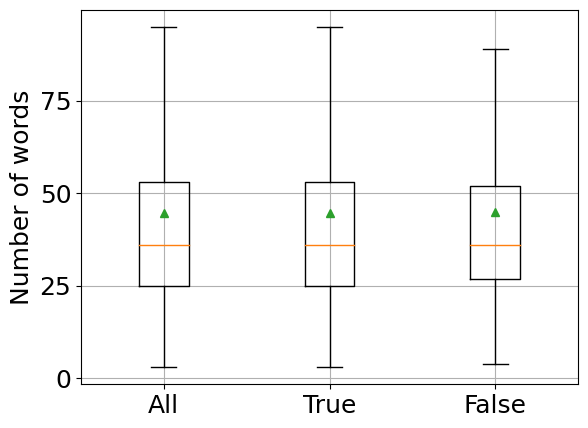

In [ ]:
# 箱ひげ図
import matplotlib.pyplot as plt

df_true = df_result[(df_result["bert_bool"] == True) | (df_result["mlr_bool"] == True)]

fig, ax = plt.subplots()
ax.boxplot([df_result["word_count"], df_true["word_count"], df_false["words"]], labels=["All", "True", "False"], showmeans=True, sym="")
# ax.boxplot([df_result["word_count"], df_true["word_count"], df_false["words"]], labels=["all", "true", "false"], showmeans=True, whis=[0, 100])

# 縦軸のラベルを設定
plt.ylabel('Number of words')

plt.rcParams["font.size"] = 24
plt.tight_layout()



plt.grid() # 横線ライン
plt.show()

In [ ]:
# 箱ひげ図をpdfで保存
from matplotlib.backends.backend_pdf import PdfPages

#PDFのインスタンスを作成
pdf = PdfPages("boxplot_word.pdf")

#PDFファイルにグラフを追加していく
pdf.savefig(fig)

#PDFファイルを閉じる
pdf.close()

In [ ]:
# 平均値
print(df_result["word_count"].mean())
print(df_true["word_count"].mean())
print(df_false["word_count"].mean())

44.679832774463264
44.65729529111575
45.02485795454545


(array([4.910e+02, 2.102e+03, 3.692e+03, 4.363e+03, 3.886e+03, 2.252e+03,
        1.338e+03, 8.830e+02, 8.350e+02, 5.970e+02, 5.670e+02, 4.950e+02,
        3.450e+02, 2.400e+02, 2.370e+02, 1.190e+02, 1.010e+02, 8.200e+01,
        5.800e+01, 6.500e+01, 5.000e+01, 4.100e+01, 2.400e+01, 2.400e+01,
        1.600e+01, 8.000e+00, 6.000e+00, 7.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  3.    ,  10.9375,  18.875 ,  26.8125,  34.75  ,  42.6875,
         50.625 ,  58.5625,  66.5   ,  74.4375,  82.375 ,  90.3125,
         98.25  , 106.1875, 114.125 , 122.0625, 130.    , 137.9375,
  

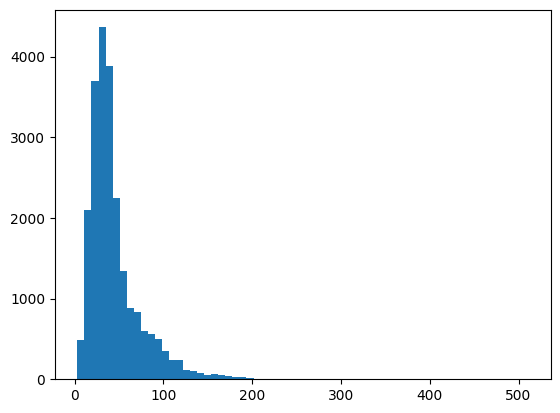

In [ ]:
# ヒストグラムを出力
plt.hist(df_result["word_count"], bins=64)

# CSVファイルに出力

In [ ]:
df_result.to_csv("MLR_df.csv")

In [ ]:
tmp = df_result[df_result["word_count"] == 4]
tmp

,cvssV3_vectorString,cvssV3_attackVector,cvssV3_attackComplexity,cvssV3_privilegesRequired,cvssV3_userInteraction,cvssV3_scope,cvssV3_confidentialityImpact,cvssV3_integrityImpact,cvssV3_availabilityImpact,cvssV3_baseScore,...,nb_CWE,CWE1,CWE2,CVE-ID,pred_cvssV3_attackVector,bert,mlr_bool,bert_bool,Description,word_count
10609,CVSS:3.1/AV:P/AC:L/PR:H/UI:N/S:U/C:H/I:H/A:H,PHYSICAL,LOW,HIGH,NONE,UNCHANGED,HIGH,HIGH,HIGH,6.2,...,1,NVD-CWE-noinfo,None,CVE-2020-16983,NETWORK,LOCAL,False,False,Azure Sphere Tampering Vulnerability,4
13136,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,NONE,REQUIRED,CHANGED,LOW,LOW,NONE,6.1,...,1,CWE-79,None,CVE-2019-19466,NETWORK,NETWORK,True,True,SCEditor 2.1.3 allows XSS.,4
13149,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,HIGH,HIGH,HIGH,8.8,...,1,CWE-352,None,CVE-2019-10642,NETWORK,NETWORK,True,True,Contao 4.7 allows CSRF.,4
